In [9]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import TwoLocal, RealAmplitudes
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.applications.ising import tsp, max_cut
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import SPSA, COBYLA

#from qiskit import IBMQ
#provider = IBMQ.load_account()

distance
 [[ 0.  5. 33. 77.]
 [ 5.  0. 36. 79.]
 [33. 36.  0. 44.]
 [77. 79. 44.  0.]]


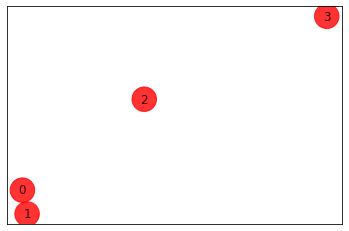

In [10]:
# Generating a graph of n nodes
n = 4

num_qubits = n ** 2
ins = tsp.random_tsp(n)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
colors = ['r' for node in G.nodes()]
pos = {k: v for k, v in enumerate(ins.coord)}
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
print('distance\n', ins.w)

order = (0, 1, 2, 3) Distance = 162.0
order = (0, 1, 3, 2) Distance = 161.0
Best order from brute force = (0, 1, 3, 2) with total distance = 161.0


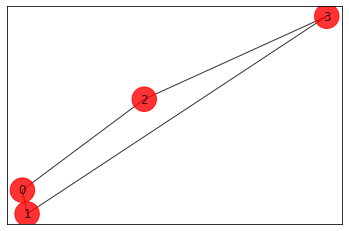

In [11]:
from itertools import permutations

def brute_force_tsp(w, N):
    a=list(permutations(range(1,N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Distance = ' + str(distance))
    return last_best_distance, best_order
  
best_distance, best_order = brute_force_tsp(ins.w, ins.dim)
print('Best order from brute force = ' + str(best_order) + ' with total distance = ' + str(best_distance))

def draw_tsp_solution(G, order, colors, pos):
    G2 = G.copy()
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

draw_tsp_solution(G, best_order, colors, pos)

In [12]:
qubitOp, offset = tsp.get_operator(ins)

energy: [-1600387.+0.j]
tsp objective: [161.+0.j]
feasible: True
solution: [0, 1, 3, 2]
solution objective: 161.0


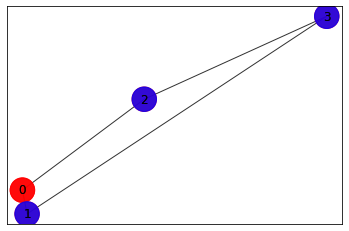

In [13]:
### Checking that the full Hamiltonian gives the right cost 
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector

from qiskit.aqua.algorithms import NumPyEigensolver
ee = NumPyEigensolver(qubitOp, k=1)
result = ee.run()

print('energy:', result['eigenvalues'])
print('tsp objective:', result['eigenvalues'] + offset)
x = sample_most_likely(result['eigenstates'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

colors = ['r' if tsp.get_tsp_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

In [14]:
# Callback to print VQE iterations
def vqe_callback(count, params, mean, std):
    #print(count, params, mean, std)
    print(count, mean, std)

In [ ]:
seed = 999

spsa = SPSA(max_trials=100)
#ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
#ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
ry = RealAmplitudes(qubitOp.num_qubits, reps=3, entanglement='full')

vqe = VQE(qubitOp, ry, spsa, callback=vqe_callback)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

1 158079.341796875 25181.970544814478
2 165489.42578125 25641.122304980283
3 117030.3369140625 24245.09841299478
4 190698.5234375 24490.566957914383
5 23645.52734375 24606.250305866295
6 274908.42578125 24881.820613019874
7 166867.375 23948.564148820944
8 231908.3876953125 25287.344691808506
9 86352.8583984375 24970.03415648198
10 244640.853515625 24392.07417779021
11 232118.65234375 25688.16141905743
12 90464.203125 23749.82878956691


In [ ]:
plot_histogram(result.eigenstate)